In [14]:
import music_data_analysis as analysis
from music_data_analysis.data.pianoroll import Pianoroll
from pathlib import Path

ds = analysis.Dataset(Path('W:/music/music-data-analysis/data'))

In [15]:
def get_sim(a:Pianoroll, b:Pianoroll):
    pitch_shift_search = [0,-12,12]
    num_overlaps_list = []
    for pitch_shift in pitch_shift_search:
        num_overlaps = get_num_overlaps(a, b, pitch_shift)
        num_overlaps_list.append(num_overlaps)
    return max(num_overlaps_list)

def get_num_overlaps(a:Pianoroll, b:Pianoroll, pitch_shift:int):
    num_overlaps = 0
    i = 0
    j = 0
    i_max = len(a.notes)
    j_max = len(b.notes)
    seen_pitch = [0]*128
    denom = 0
    while i < i_max and j < j_max:
        note_a = a.notes[i]
        note_b = b.notes[j]
        
        if note_a.onset < note_b.onset:
            i += 1
        elif note_a.onset > note_b.onset:
            j += 1
        else:
            if note_a.pitch == note_b.pitch + pitch_shift and seen_pitch[note_a.pitch] < 2:
                num_overlaps += 1
            i += 1
            j += 1
        
        if seen_pitch[note_a.pitch] < 2:
            denom += 1
        if seen_pitch[note_b.pitch] < 2:
            denom += 1
        seen_pitch[note_a.pitch] += 1
        seen_pitch[note_b.pitch] += 1
    if denom == 0:
        return 0
    return num_overlaps / denom * 2


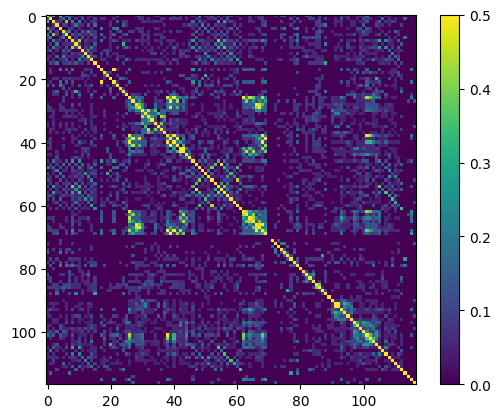

In [26]:
from matplotlib import pyplot as plt
import torch


pr = ds.get_song('24').read_pianoroll('pianoroll')
mat = torch.zeros((pr.duration//32, pr.duration//32))
for i in range(pr.duration//32):
    for j in range(i, pr.duration//32):
        sim = get_sim(pr.slice(i*32, (i+1)*32), pr.slice(j*32, (j+1)*32))
        mat[i, j] = sim
        mat[j, i] = sim

plt.imshow(mat, vmax=0.5)
plt.colorbar()
plt.show()


In [85]:

def cut(W:torch.Tensor, A:torch.Tensor, B:torch.Tensor):
    s = 0
    for u in A:
        for v in B:
            s += W[u, v]
    return s

def assoc(W:torch.Tensor, A:torch.Tensor):
    return W.sum(1)[A].sum()

def ncut(W:torch.Tensor, A:torch.Tensor, B:torch.Tensor):
    return cut(W, A, B) / assoc(W, A) + cut(W, A, B) / assoc(W, B)

def search_cut(W:torch.Tensor, eigvec:torch.Tensor, num_search:int=10)->tuple[torch.Tensor, torch.Tensor,float]:
    best_cut_point = 0
    best_ncut = float('inf')

    for cut_point in torch.linspace(eigvec.min(), eigvec.max(), num_search):
        A = torch.where(eigvec < cut_point)[0]
        B = torch.where(eigvec >= cut_point)[0]
        ncut_for_this_cut_point = ncut(W, A, B)
        if ncut_for_this_cut_point < best_ncut:
            best_ncut = ncut_for_this_cut_point.item()
            best_cut_point = cut_point
    res_A = torch.where(eigvec < best_cut_point)[0]
    res_B = torch.where(eigvec >= best_cut_point)[0]
    return res_A, res_B, best_ncut


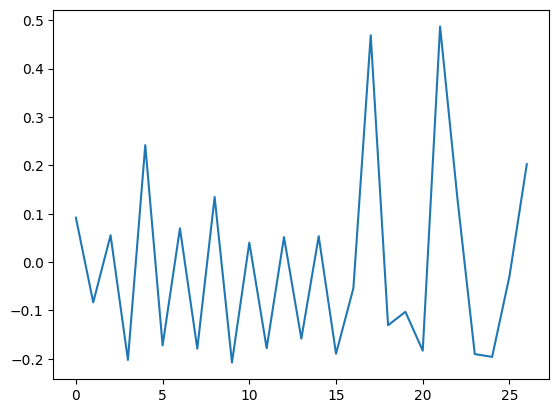

In [86]:
W = mat[:27, :27]+0.1

def ncut_eig(W):
    D = torch.diag(W.sum(dim=1))
    D_inv = torch.diag(1 / torch.diag(D))
    eigvals, eigvecs = torch.linalg.eig(D_inv @ (D - W))
    # use the second smallest eigenvalue's eigenvector
    eigvec = eigvecs[:, torch.argsort(eigvals.real)[1]].real
    return eigvec

def remove_index(mat, index):
    '''
    Remove the index-th row and column from the matrix
    '''
    row_removed = torch.cat([mat[:index, :], mat[index+1:, :]])
    col_removed = torch.cat([row_removed[:, :index], row_removed[:, index+1:]], dim=1)
    return col_removed

def remove_indices(mat, indices):
    '''
    Remove the indices-th rows and columns from the matrix
    '''
    for index in sorted(indices, reverse=True):
        mat = remove_index(mat, index)
    return mat

eigvec = ncut_eig(W)
plt.plot(eigvec)

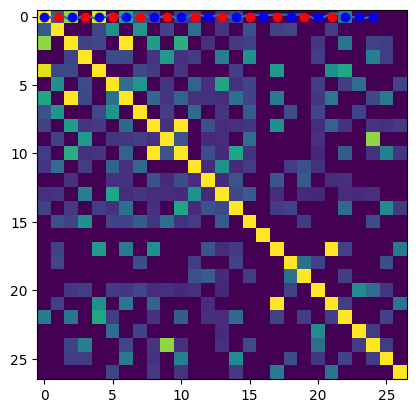

0.6708376407623291


In [87]:
eigvec = ncut_eig(remove_indices(W, [17,21]))
plt.plot(eigvec)

A, B, ncut_val = search_cut(W, eigvec)
plt.imshow(W, vmax=0.5)
plt.plot(A, torch.zeros(len(A)), 'ro')
plt.plot(B, torch.zeros(len(B)), 'bo')
plt.show()
print(ncut_val)


In [142]:
import pprint


def recursive_ncut(W:torch.Tensor, real_indices:torch.Tensor|None=None, stop_ncut:float=1000):
    '''
    Recursively cut the matrix until the ncut value is larger than the stop_ncut
    Args:
        W (torch.Tensor): The weight matrix
        stop_ncut (float, optional): The ncut value to stop the recursion. Defaults to 1.
    '''
    if real_indices is None:
        real_indices = torch.arange(W.shape[0])

    if W.shape[0] <=2:
        return real_indices.tolist()

    eigvec = ncut_eig(W)
    A, B, ncut_val = search_cut(W, eigvec, num_search=10)
    if ncut_val > stop_ncut:
        return real_indices.tolist()
    else:
        A_indices = real_indices[A]
        B_indices = real_indices[B]
        return [
            recursive_ncut(remove_indices(W, B), A_indices, stop_ncut),
            recursive_ncut(remove_indices(W, A), B_indices, stop_ncut)
        ]
    
res = recursive_ncut(mat+0.1)

In [143]:
pprint.pprint(res)

[[[[[[103], [[102], [[101], [[40, 68], [26, 38]]]]],
    [[[97], [[[62], [42, 64]], [63, 65]]], [[105], [93, 115]]]],
   [[[[28, 66], [29, 67]], [30]], [[[69], [[27, 39], [41]]], [43]]]],
  [17, 21]],
 [[[[[[48], [52, 60]], [[[25, 95], [31, 35]], [85, 86]]],
    [[[[98], [[14], [22, 99]]], [[[12, 50], [58, 109]], [79]]],
     [[111], [[[[46], [[54, 56], [8, 10]]], [107]], [2, 6]]]]],
   [[[78], [[0, 4], [75]]], [72, 74]]],
  [[[[[[15, 88], [9, 24]], [[[106], [61, 112]], [[53], [47, 55]]]],
     [[[[[33], [32, 37]], [34, 36]], [[[83], [82, 84]], [81]]],
      [[[1, 7], [77, 113]],
       [[[[114], [[[89], [[16], [70, 116]]], [80]]], [[71, 73], [76]]],
        [18, 19]]]]],
    [[[23], [20, 104]],
     [[[[5, 13], [100]], [59, 110]],
      [[87], [[[[44, 45], [[49], [[51, 57], [108]]]], [3]], [11]]]]]],
   [[[96], [[91, 92], [94]]], [90]]]]]


In [144]:
from typing import Callable
from treelib import Node, Tree

tree = Tree()

# plot the result, which is list of lists... of indices

def add_to_tree(tree:Tree, parent:Node|None, indices:list, name_func:Callable[[int], str] = lambda x: str(x)):
    if isinstance(indices, int):
        tree.create_node(name_func(indices), name_func(indices), parent=parent)
    elif len(indices) == 1:
        tree.create_node(name_func(indices[0]), name_func(indices[0]), parent=parent)
    else:
        left, right = indices
        node = tree.create_node('.',parent=parent)
        add_to_tree(tree, node, left, name_func)
        add_to_tree(tree, node, right, name_func)

add_to_tree(tree, None, res, lambda x: str(x+1))
print(tree.show(stdout=False))



.
├── .
│   ├── .
│   │   ├── .
│   │   │   ├── .
│   │   │   │   ├── .
│   │   │   │   │   ├── .
│   │   │   │   │   │   ├── .
│   │   │   │   │   │   │   ├── .
│   │   │   │   │   │   │   │   ├── 41
│   │   │   │   │   │   │   │   └── 69
│   │   │   │   │   │   │   └── .
│   │   │   │   │   │   │       ├── 27
│   │   │   │   │   │   │       └── 39
│   │   │   │   │   │   └── 102
│   │   │   │   │   └── 103
│   │   │   │   └── 104
│   │   │   └── .
│   │   │       ├── .
│   │   │       │   ├── .
│   │   │       │   │   ├── .
│   │   │       │   │   │   ├── .
│   │   │       │   │   │   │   ├── 43
│   │   │       │   │   │   │   └── 65
│   │   │       │   │   │   └── 63
│   │   │       │   │   └── .
│   │   │       │   │       ├── 64
│   │   │       │   │       └── 66
│   │   │       │   └── 98
│   │   │       └── .
│   │   │           ├── .
│   │   │           │   ├── 116
│   │   │           │   └── 94
│   │   │           └── 106
│   │   └── .
│   │       ├── .
│   │       │   ├── .
│

In [108]:
from scipy.cluster.hierarchy import linkage
linkage([[0,1],[1,2],[2,3],[3,4]])

array([[0.        , 1.        , 1.41421356, 2.        ],
       [2.        , 4.        , 1.41421356, 3.        ],
       [3.        , 5.        , 1.41421356, 4.        ]])

In [29]:
# Example matrices
D = torch.diag(torch.tensor([3.0, 4.0, 5.0]))  # Diagonal matrix
W = torch.tensor([[1.0, 0.5, 0.2], 
                  [0.5, 2.0, 0.3], 
                  [0.2, 0.3, 1.0]])  # Weight matrix

# Ensure D is invertible
D_inv = torch.diag(1 / torch.diag(D))

# Compute the transformed matrix
A = D_inv @ (D - W)

# Solve the eigenvalue problem
eigenvalues, eigenvectors = torch.linalg.eig(A)

# The eigenvalues are λ, and the eigenvectors are the corresponding x
print("Eigenvalues:", eigenvalues)
print("Eigenvectors:", eigenvectors)

Eigenvalues: tensor([0.3991+0.j, 0.7483+0.j, 0.8193+0.j])
Eigenvectors: tensor([[-0.5517+0.j, -0.8712+0.j, -0.2987+0.j],
        [-0.8150+0.j,  0.4755+0.j, -0.1059+0.j],
        [-0.1770+0.j, -0.1222+0.j,  0.9485+0.j]])


In [81]:


best_cut_point = search_cut(W, eigvec)
print(best_cut_point)

(tensor([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21]), tensor([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 23, 24]))
